```
Coursework Assignment: Building a Regression Model
University of London
BSc in Computer Science
CM3005, Data Science
Hudson Leonardo MENDES
hlm12@student.london.ac.uk
```


# I. Introduction


## Domain-specific area


## Dataset


## Objectives


# II. Implementation


## Preprocessing


In [1]:
import pathlib

data_folderpath = pathlib.Path("./data")

ppd_folderpath = data_folderpath / "uk-ppd"
inflation_filepath = data_folderpath / "uk-ons/ons-inflation-1989-2022.csv"
interest_filepath = data_folderpath / "uk-boe/boe-interest-1975-2022.csv"


In [2]:
import pandas as pd


In [3]:
# https://www.gov.uk/guidance/about-the-price-paid-data
ppd_df = pd.concat(
    [
        pd.read_csv(
            ppd_filepath,
            nrows=100,
            compression="zip",
            names=[
                "id",
                "price",
                "date",
                "postcode",
                "property_type",
                "old_or_new",
                "duration",
                "paon",
                "saon",
                "street",
                "locality",
                "town_city",
                "district",
                "county",
                "ppd_category_type",
                "record_status",
            ],
        )
        for ppd_filepath in ppd_folderpath.glob("*.zip")
    ]
)
ppd_df["postgroup"] = ppd_df["postcode"].map(lambda x: str(x).split(" ")[0])
ppd_df["date"] = pd.to_datetime(ppd_df["date"])
ppd_df = ppd_df[
    [
        "date",
        "postgroup",
        "property_type",
        "old_or_new",
        "duration",
        "ppd_category_type",
        "price",
    ]
]
ppd_df = ppd_df.astype(
    {
        "postgroup": "category",
        "property_type": "category",
        "old_or_new": "category",
        "duration": "category",
        "ppd_category_type": "category",
        "price": "double",
    }
)
ppd_df.sample(n=5)


,date,postgroup,property_type,old_or_new,duration,ppd_category_type,price
75,2022-03-08,DA11,S,N,F,B,400000.0
7,2021-12-23,SL5,F,N,L,B,875000.0
32,2020-12-11,SO19,S,N,F,A,250000.0
28,2021-06-29,BS14,S,N,F,B,300000.0
65,2018-10-26,TQ2,O,N,F,B,3896787.0


In [4]:
import re
import string
from datetime import date

inflation_date_pattern = re.compile(r"([\d]{4})(?:\s+([\w]{3}))?")
inflation_month_names = [
    "JAN",
    "FEB",
    "MAR",
    "APR",
    "MAY",
    "JUN",
    "JUL",
    "AUG",
    "SEP",
    "OCT",
    "NOV",
    "DEC",
]
inflation_month_index = {mn: ix + 1 for (ix, mn) in enumerate(inflation_month_names)}
inflation_month_index["Q1"] = 1
inflation_month_index["Q2"] = 4
inflation_month_index["Q3"] = 7
inflation_month_index["Q3"] = 10

inflation_acceptable_numeric_chars = string.digits + ".,"


def extract_inflation_date(x: str) -> date:
    match = next(inflation_date_pattern.finditer(x), None)
    if match:
        group_count = len(match.groups())
        if group_count >= 1:
            year = int(match.group(1))
            month = 1
            month_name = match.group(2)
            if group_count > 1 and month_name:
                month_name = month_name.strip().upper()
                month = inflation_month_index.get(month_name)
            return date(year, month, 1)


def extract_inflation_rate(x: str) -> float:
    x = str(x)
    if all([c in inflation_acceptable_numeric_chars for c in x]):
        return float(x)
    return None


inflation_df = pd.read_csv(inflation_filepath)
inflation_df["date"] = inflation_df["Title"].map(extract_inflation_date)
inflation_df["date"] = pd.to_datetime(inflation_df["date"])
inflation_df["rate"] = inflation_df["CPIH ANNUAL RATE 00: ALL ITEMS 2015=100"].map(
    extract_inflation_rate
)
inflation_df["rate"] = inflation_df["rate"].astype("float", errors="ignore")
inflation_df = inflation_df[["date", "rate"]]
inflation_df = inflation_df.dropna()
inflation_df = inflation_df.set_index("date").sort_index()
inflation_df.sample(n=5)


,rate
date,
2013-01-01,2.4
2003-04-01,1.5
1994-06-01,2.3
2022-09-01,8.8
2007-11-01,2.2


In [5]:
interest_df = pd.read_csv(interest_filepath)
interest_df["date"] = pd.to_datetime(interest_df["Date Changed"])
interest_df["rate"] = interest_df["Rate"].astype("float")
interest_df = interest_df[["date", "rate"]]
interest_df = interest_df.set_index("date").sort_index()
interest_df.sample(n=5)


,rate
date,
1984-07-06,10.00
1978-06-08,10.00
1988-02-01,8.88
1988-08-08,10.88
1987-11-04,8.88


## Statistical Summary


## Data visualisation


In [6]:
%matplotlib inline

In [11]:
import numpy as np
import matplotlib.pyplot as plt


In [8]:
max_rate = max(interest_df.rate.max(), inflation_df.rate.max())
min_intersecting_date = max(interest_df.index.min(), inflation_df.index.min())
max_intersecting_date = min(interest_df.index.max(), inflation_df.index.max())


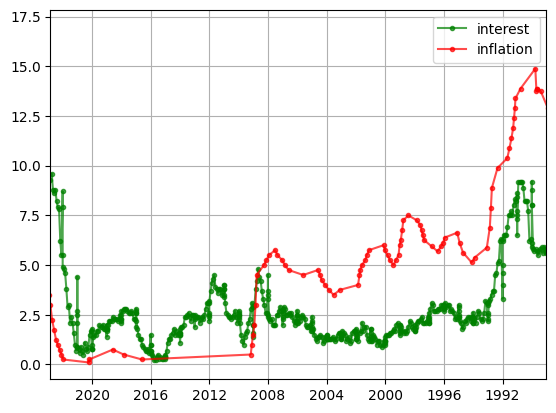

In [9]:
ax = plt.subplot()
ax.grid(visible=True)
ax.set_xlim(left=max_intersecting_date, right=min_intersecting_date)
ax.plot(inflation_df, "g.-", alpha=0.7)
ax.plot(interest_df, "r.-", alpha=0.7)
ax.legend(["interest", "inflation"])


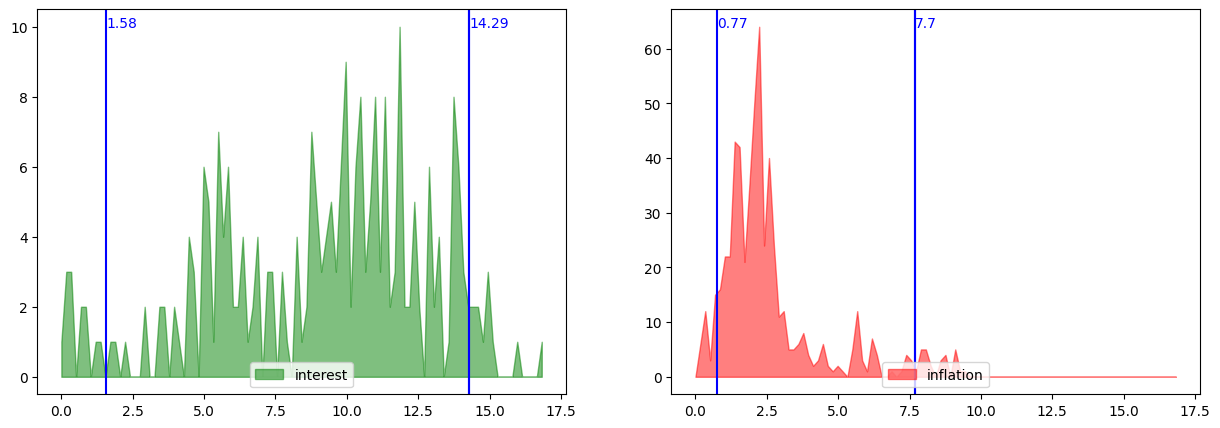

In [66]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))

x = np.linspace(0.0, max_rate, 100)

def plot_rate_distributions(ax, df: pd.DataFrame, label: str, color: str):
    df = df.copy()
    df["bin"] = pd.cut(df["rate"], bins=x)
    y = list(df.groupby("bin").count()["rate"])
    ax.fill_between(x[:-1], 0., y, color=color, alpha=0.5)
    for quantile in df.rate.quantile([0.05, 0.95]):
        ax.axvline(x=quantile, color='blue')
        ax.annotate(str(round(quantile, 2)), xy=(quantile, max(y)), color='blue')
    ax.axvline(x=quantile, color='blue')
    ax.legend([label], loc="lower center")


plot_rate_distributions(
    ax=axes[0],
    df=interest_df.copy(),
    label="interest",
    color="green")

plot_rate_distributions(
    ax=axes[1],
    df=inflation_df.copy(),
    label="inflation",
    color="red")


## Machine learning model


# III. Conclusions


## Performance of results


## Closing remarks/statements
